# RNN for Predicting Characters

In [1]:
import os
import numpy as np
import collections
import pickle
import argparse
import tensorflow as tf
import time
import matplotlib.pyplot as plt
%matplotlib inline

/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [96]:
parser = argparse.ArgumentParser()
parser.add_argument('--data_dir', default='./')
parser.add_argument('--save_dir', default='./')
# Dimension of hidden layer variables h and c
parser.add_argument('--num_units', default=128*2)
parser.add_argument('--batch_size', default=64)
# Number of steps in each batch for training
parser.add_argument('--num_steps', default=75)
parser.add_argument('--num_epochs', default=30)
# Time step
parser.add_argument('--lr', default=0.002)
# Number of possible inputs/outputs 
parser.add_argument('--num_chars')
parser.add_argument('--num_batches',default=20)
args, unparsed = parser.parse_known_args()

In [97]:
args

Namespace(batch_size=64, data_dir='./', lr=0.002, num_batches=20, num_chars=None, num_epochs=30, num_steps=75, num_units=256, save_dir='./')

In [98]:
unparsed

['-f',
 '/home/xinyuw/.local/share/jupyter/runtime/kernel-1cdfa667-8f3c-4d9c-af7e-5ed427250594.json']

In [99]:
def timer(start, end):
    hrs, rem = divmod(end-start, 3600)
    mins, secs = divmod(rem, 60)
    print('{:0>2} hours {:0>2} minutes {:05.2f} seconds'.format(int(hrs), int(mins), secs))

In [100]:
class TextLoader():

    def __init__(self, data_dir, batch_size=64, seq_length=50, encoding='utf-8'):
        self.data_dir = data_dir
        self.encoding = encoding
        self.batch_size = batch_size
        self.seq_length = seq_length

        self.input_file = os.path.join(data_dir, 'tinyshakespeare.txt')
        self.vocab_file = os.path.join(data_dir, 'vocab.pkl')
        # Numeric file of characters translated to indices.
        self.tensor_file = os.path.join(data_dir, 'data.npy')
        
        if not (os.path.exists(self.vocab_file) and os.path.exists(self.tensor_file)):
            print('it seems we havent processed the text data yet: reading the shakespear')
            self.preprocess(self.input_file, self.vocab_file, self.tensor_file)
        else:
            print('there are preprocessed data - lets load it')
            self.load_preprocessed(self.vocab_file, self.tensor_file)

        self.create_batches()
        self.reset_batch_pointer()

    # Create numeric file.
    def preprocess(self, input_file=None, vocab_file=None, tensor_file=None, saveit=True):
        if input_file is not None:
            self.input_file = input_file
        if vocab_file is not None:
            self.vocab_file = vocab_file
        if tensor_file is not None:
            self.tensor_file = tensor_file

        with open(self.input_file, 'r') as f:
            data = f.read()
        #data = data.lower()
        self.total_length = len(data)
        counter = collections.Counter(data)
        count_pairs = sorted(counter.items(), key=lambda x: -x[1])
        self.chars, _ = zip(*count_pairs)
        self.vocab_size = len(self.chars)
        self.vocab_to_idx = dict(zip(self.chars, range(len(self.chars))))
        self.idx_to_vocab = dict(zip(self.vocab_to_idx.values(), self.vocab_to_idx.keys()))

        if saveit:
            with open(self.vocab_file, 'wb') as f:  # saving dictionary so we don't compute it again
                pickle.dump(self.chars, f)
            self.tensor = np.array(list(map(self.vocab_to_idx.get, data)))
            np.save(self.tensor_file, self.tensor)  # saving the numerified data
    # Load numeric file create dictionaries for char2idx and back
    def load_preprocessed(self, vocab_file=None, tensor_file=None):
        if vocab_file is not None:
            self.vocab_file = vocab_file
        if tensor_file is not None:
            self.tensor_file = tensor_file

        with open(self.vocab_file, 'rb') as f:
            self.chars = pickle.load(f)

        # attributes
        self.vocab_size = len(self.chars)
        self.vocab = dict(zip(self.chars, range(self.vocab_size)))
        self.vocab_to_idx = dict(zip(self.chars, range(len(self.chars))))
        self.idx_to_vocab = dict(zip(self.vocab_to_idx.values(), self.vocab_to_idx.keys()))
        self.tensor = np.load(tensor_file)
        self.num_batches = int(self.tensor.size / (self.batch_size * self.seq_length))
            
    # tensor size = the length of the entire data sequence
    # divide into batch_size sub sequences and stack
    # cut those by seq_length to produce batches of [batch size, seq_length] sized examples
    def create_batches(self):

        
        self.num_batches = int(self.tensor.size / (self.batch_size * self.seq_length))

        if self.num_batches == 0:
            assert False, 'Not enough data. Make seq_length and/or batch_size smaller'

        self.tensor = self.tensor[:self.num_batches * self.batch_size * self.seq_length]  # so we get an even divide
        xdata = self.tensor
        ydata = np.copy(self.tensor)

        # ydata is one step ahead of x and last item is first item of x 
        # to get sequences of same length    
        ydata[:-1] = xdata[1:] 
        ydata[-1] = xdata[0]

        self.x_batches = np.split(xdata.reshape(self.batch_size, -1), self.num_batches, 1)
        self.y_batches = np.split(ydata.reshape(self.batch_size, -1), self.num_batches, 1)
        
        self.train_num_batches=np.int32(self.num_batches*.8)
        self.test_num_batches=self.num_batches-self.train_num_batches
        self.train_x_batches=self.x_batches[0:self.train_num_batches]
        self.train_y_batches=self.y_batches[0:self.train_num_batches]
        self.test_x_batches=self.x_batches[self.train_num_batches:]
        self.test_y_batches=self.y_batches[self.train_num_batches:]

        # xdata: L length
        # xdata reshaped: batch_size, (L/batch_size) length following natural indexing
        # np.split: into num batches batches along the width(sentence)

    def next_batch_train(self):
        x, y = self.train_x_batches[self.pointer], self.train_y_batches[self.pointer]
        self.pointer += 1
        return x,y
    
    def next_batch_test(self):
        x, y = self.test_x_batches[self.pointer], self.test_y_batches[self.pointer]
        self.pointer += 1
        return x,y

    def reset_batch_pointer(self):
        self.pointer = 0

In [101]:
loader = TextLoader(args.data_dir, batch_size=args.batch_size, seq_length=args.num_steps)
args.num_chars = loader.vocab_size
print('num chars',args.num_chars)
print('num batches',loader.num_batches)

there are preprocessed data - lets load it
num chars 65
num batches 232


In [102]:
args.num_chars

65

In [103]:
def network(myLSTMCell,inputs,targets):

    with tf.variable_scope('embedding_matrix'):
        embedding = tf.get_variable('embedding', [args.num_chars, args.num_units])
        embedded_inputs = tf.nn.embedding_lookup(embedding, inputs)
        inputs_list = tf.unstack(embedded_inputs, axis=1)  # shape: a list of [batch_size, num_units] length num_steps

    with tf.variable_scope('LSTMCell') as myscope:
        cell = myLSTMCell(args.num_units)
        init_state = cell.zero_state(args.batch_size, tf.float32)
        state = init_state
        outputs = []

        for time_, input in enumerate(inputs_list):
            if time_ > 0:
                myscope.reuse_variables()
           
            output, state = cell(input, state)
            outputs.append(output)
    # All hidden outputs for each batch and every step in the batch are reshaped
    # as one long matrix to be transformed to logits and compared to targets.
        output_reshaped = tf.reshape(tf.concat(outputs, 1), [-1, args.num_units])

        final_state = state

    with tf.variable_scope('regression'):
        W = tf.get_variable('W', [args.num_units, args.num_chars])
        b = tf.get_variable('b', [args.num_chars], initializer=tf.constant_initializer(0.0))
        logits = tf.matmul(output_reshaped, W) + b
        prob = tf.nn.softmax(logits)

    with tf.variable_scope('cost'):
        targets_straightened = tf.reshape(targets, [-1])
        crossentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, 
                                                    labels=targets_straightened)
        loss = tf.reduce_mean(crossentropy)
        cost = loss/args.batch_size/args.num_steps

    with tf.variable_scope('optimizer'):
        train_step = tf.train.AdamOptimizer(args.lr).minimize(loss)

    with tf.variable_scope('saver'):
        saver = tf.train.Saver()
    return init_state, train_step, loss, final_state, saver, prob

In [104]:
def trainer(myCell,num_batches=None):
    
    start_time = time.time()
    tf.reset_default_graph()
    # Define the placeholders
    with tf.variable_scope('placeholders'):
            inputs = tf.placeholder(tf.int32, [args.batch_size, args.num_steps])
            targets = tf.placeholder(tf.int32, [args.batch_size, args.num_steps])
    # Create the network
    init_state, train_step, loss, final_state, saver, prob=network(myCell,inputs,targets)
    print('train_num_batches',loader.train_num_batches)
    
    if (num_batches is None):
        num_batches=loader.train_num_batches

    with tf.Session() as sess:
         
        sess.run(tf.global_variables_initializer())
        # computation graph for training
        training_losses = []

        for epoch in range(args.num_epochs):
            loader.reset_batch_pointer()
            state_ = sess.run(init_state)
            training_loss = 0

            for batch in range(num_batches):

                x, y = loader.next_batch_train()

                feed_dict = dict()
                feed_dict[inputs] = x
                feed_dict[targets] = y
                
                if ('RNN' in myCell.__name__):
                    feed_dict[init_state] = state_
                else:
                    feed_dict[init_state.c] = state_.c
                    feed_dict[init_state.h] = state_.h

                train_loss_, state_, _ = sess.run([loss, final_state, train_step], feed_dict=feed_dict)
                training_loss += train_loss_
            training_loss=training_loss/num_batches
            print('epoch:', epoch, 'loss:',  training_loss)
            training_losses.append(training_loss)
        saver.save(sess, os.path.join(args.save_dir, 'saved_model'))
    
    end_time = time.time()
    
    timer(start_time, end_time)
    return(training_losses)

In [88]:
def synthesize_example_sentences(cell):
    print("*****Synthesizing: What is the meaning of life\n")
    Synthesize(cell,"What is the meaning of life")
    print("\n*****Synthesizing: I will be king, or die.\n")
    Synthesize(cell,"I will be king, or die.")
    print("\n*****Synthesizing: Most noble sir\n")
    Synthesize(cell,"Most noble sir")
    print("\n*****Synthesizing: O my lord\n")
    Synthesize(cell,"O my lord")
    print("\n*****Synthesizing: Farewell\n")
    Synthesize(cell,"Farewell")

# I. Experiment with Different Architectures

## Basic LSTM

In [105]:
LSTMStateTuple = collections.namedtuple("LSTMStateTuple", ("c", "h"))

class MyBasicLSTMCell(tf.contrib.rnn.BasicLSTMCell):

    def build(self, inputs_shape):

        input_depth = inputs_shape[1].value
        self._kernel = self.add_variable(name="kernel", shape=[input_depth + self._num_units, 4 * self._num_units])
        self._bias = self.add_variable(name="bias", shape=[4 * self._num_units], initializer=tf.zeros_initializer())

        self.built = True

    def call(self, inputs, state):

        one = tf.constant(1, dtype=tf.int32)
        c, h = state

        gate_inputs = tf.matmul(tf.concat([inputs, h], axis=1), self._kernel) + self._bias

        input_gate_weights, input_weights, forget_gate_weights, output_gate_weights = tf.split(
            value=gate_inputs, num_or_size_splits=4, axis=one)

        # forget gating
        forget_bias_tensor = tf.constant(1.0, dtype=forget_gate_weights.dtype)
        forget_gate = tf.sigmoid(forget_gate_weights + forget_bias_tensor)
        gated_memory = c * forget_gate

        # input gating
        processed_new_input = tf.tanh(input_weights)
        input_gate = tf.sigmoid(input_gate_weights)
        gated_input = input_gate * processed_new_input

        # updating memory
        new_c = gated_memory + gated_input

        # output gating
        processed_memory = tf.tanh(new_c)
        output_gate = tf.sigmoid(output_gate_weights)
        new_h = processed_memory * output_gate

        new_state = tf.nn.rnn_cell.LSTMStateTuple(new_c, new_h)

        return new_h, new_state

In [106]:
re_lstm_basic = trainer(MyBasicLSTMCell)

train_num_batches 185
epoch: 0 loss: 2.3980559980547107
epoch: 1 loss: 1.8184556213585106
epoch: 2 loss: 1.651059239619487
epoch: 3 loss: 1.5597178188530174
epoch: 4 loss: 1.5010102967958192
epoch: 5 loss: 1.45853025268864
epoch: 6 loss: 1.424926512305801
epoch: 7 loss: 1.3976229577451138
epoch: 8 loss: 1.3754076397096788
epoch: 9 loss: 1.3573355868056014
epoch: 10 loss: 1.340587642386153
epoch: 11 loss: 1.3258719482937376
epoch: 12 loss: 1.312723396919869
epoch: 13 loss: 1.3012037264334189
epoch: 14 loss: 1.2910345779882895
epoch: 15 loss: 1.2816276492299261
epoch: 16 loss: 1.272867778829626
epoch: 17 loss: 1.2651023387908935
epoch: 18 loss: 1.2571350464949738
epoch: 19 loss: 1.2494089004155753
epoch: 20 loss: 1.242612115112511
epoch: 21 loss: 1.2365489837285635
epoch: 22 loss: 1.2309693574905396
epoch: 23 loss: 1.2262815552788813
epoch: 24 loss: 1.219398352262136
epoch: 25 loss: 1.2137903484138282
epoch: 26 loss: 1.2089055808814797
epoch: 27 loss: 1.2049857171806129
epoch: 28 loss: 1

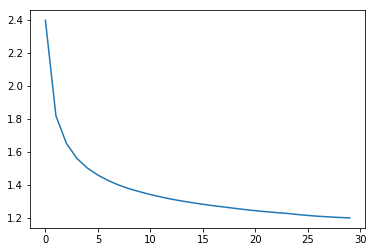

In [107]:
x = np.array(range(args.num_epochs))
plt.plot(x, re_lstm_basic)

In [108]:
Tester(MyBasicLSTMCell)

there are preprocessed data - lets load it
[39  5  1  7  1  0  4  7  1  0 15  3 13  0 20  3  9  8 20  0  2  3 12  4
 15 44]
INFO:tensorflow:Restoring parameters from saved_model
num_batches 47
test loss: 1.3974282107454665


1.3974282107454665

In [109]:
synthesize_example_sentences(MyBasicLSTMCell)

*****Synthesizing: What is the meaning of life

there are preprocessed data - lets load it
[39  5  4  2  0  9  6  0  2  5  1  0 14  1  4  8  9  8 20  0  3 18  0 11
  9 18  1]
INFO:tensorflow:Restoring parameters from saved_model
What is the meaning of lifer
deficed with a success of my state and set her,
With the condition, with a thought how to mean.
An

*****Synthesizing: I will be king, or die.

there are preprocessed data - lets load it
[21  0 17  9 11 11  0 22  1  0 28  9  8 20 16  0  3  7  0 12  9  1 25]
INFO:tensorflow:Restoring parameters from saved_model
I will be king, or die.

LADY MONCA:
It is breathe will be true to the same
And then a strut, that I will be selush
I think

*****Synthesizing: Most noble sir

there are preprocessed data - lets load it
[42  3  6  2  0  8  3 22 11  1  0  6  9  7]
INFO:tensorflow:Restoring parameters from saved_model
Most noble sires.

KATHARINA:
'tis all things and tell me with their hound;
With his prisoner thrown and that I wa

*****Synthesi

## Basic RNN

In [90]:
class MyBasicRNNCell(tf.contrib.rnn.BasicRNNCell):

    def build(self, inputs_shape):

        input_depth = inputs_shape[1].value
        
        self._kernel = self.add_variable(name="kernel_hidden", shape=[input_depth + self._num_units, self._num_units])
        self._bias = self.add_variable(name="bias_hidden", shape=[self._num_units], initializer=tf.zeros_initializer())
        
        self.built = True

    def call(self, inputs, state):
        """Most basic RNN: output = new_state = act(W * input + U * state + B)."""
        
        output = tf.tanh(tf.matmul(tf.concat([inputs, state], 1), self._kernel) + self._bias)

        return output, output

In [62]:
re_rnn_basic = trainer(MyBasicRNNCell)

train_num_batches 185
epoch: 0 loss: 2.284122889106338
epoch: 1 loss: 1.8354029578131599
epoch: 2 loss: 1.689298420983392
epoch: 3 loss: 1.6083256399309314
epoch: 4 loss: 1.5571037956186242
epoch: 5 loss: 1.5209539754970653
epoch: 6 loss: 1.4940475676510785
epoch: 7 loss: 1.4733178125845419
epoch: 8 loss: 1.4564942952748892
epoch: 9 loss: 1.442408570083412
epoch: 10 loss: 1.4305852181202656
epoch: 11 loss: 1.4205288661492836
epoch: 12 loss: 1.4118538927387547
epoch: 13 loss: 1.4042525620073885
epoch: 14 loss: 1.3974538513132044
epoch: 15 loss: 1.3913075479301247
epoch: 16 loss: 1.385862127510277
epoch: 17 loss: 1.3812280758007152
epoch: 18 loss: 1.378029693139566
epoch: 19 loss: 1.3749821282721855
epoch: 20 loss: 1.3709494693859203
epoch: 21 loss: 1.3671146425040992
epoch: 22 loss: 1.3639348474708763
epoch: 23 loss: 1.3606044066918863
epoch: 24 loss: 1.3572446578257793
epoch: 25 loss: 1.3544155604130512
epoch: 26 loss: 1.352277794399777
epoch: 27 loss: 1.3506291331471623
epoch: 28 loss

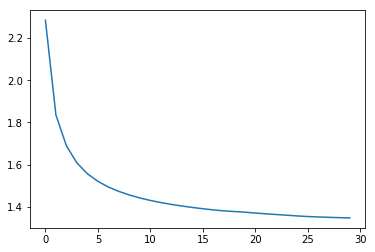

In [64]:
plt.plot(x, re_rnn_basic)

In [65]:
Tester(MyBasicRNNCell)

there are preprocessed data - lets load it
[39  5  1  7  1  0  4  7  1  0 15  3 13  0 20  3  9  8 20  0  2  3 12  4
 15 44]
INFO:tensorflow:Restoring parameters from saved_model
num_batches 47
test loss: 1.4651790679769312


1.4651790679769312

In [66]:
Synthesize(MyBasicRNNCell,"What is the meaning of life")

there are preprocessed data - lets load it
[39  5  4  2  0  9  6  0  2  5  1  0 14  1  4  8  9  8 20  0  3 18  0 11
  9 18  1]
INFO:tensorflow:Restoring parameters from saved_model
What is the meaning of lifedly and by a confoll'd.

Clown:
Would think of down to hear our lamentable death by the wise enterta


In [67]:
Synthesize(MyBasicRNNCell,"I will be king, or die.")

there are preprocessed data - lets load it
[21  0 17  9 11 11  0 22  1  0 28  9  8 20 16  0  3  7  0 12  9  1 25]
INFO:tensorflow:Restoring parameters from saved_model
I will be king, or die. Were it was befier thee was this such a sacred my base
Than the seats.

ANGELO:
I serve me to this 


In [68]:
Synthesize(MyBasicRNNCell,"Most noble sir")

there are preprocessed data - lets load it
[42  3  6  2  0  8  3 22 11  1  0  6  9  7]
INFO:tensorflow:Restoring parameters from saved_model
Most noble sirain when then. I was nembeath, and my father
With too shall not be the soul son, by a say woman.

BU


In [69]:
Synthesize(MyBasicRNNCell,"O my lord")

there are preprocessed data - lets load it
[32  0 14 15  0 11  3  7 12]
INFO:tensorflow:Restoring parameters from saved_model
O my lordy will now itself, as it weaps,
As is that have some bring our part,
That, to themsed
We shall be co


In [70]:
Synthesize(MyBasicRNNCell,"Farewell")

there are preprocessed data - lets load it
[49  4  7  1 17  1 11 11]
INFO:tensorflow:Restoring parameters from saved_model
Farewelly to seat so, blood is he could seem's leave to the war ask, by the battle to be till but stink that


## RNN - Same Number of Parameters with LSTM

In [81]:
re_rnn_4times_para = trainer(MyBasicRNNCell_4times_para)

train_num_batches 185
epoch: 0 loss: 2.239912706452447
epoch: 1 loss: 1.7488350011206961
epoch: 2 loss: 1.5976832454268997
epoch: 3 loss: 1.5170083851427645
epoch: 4 loss: 1.4667618687088426
epoch: 5 loss: 1.4297380653587548
epoch: 6 loss: 1.4017698178420195
epoch: 7 loss: 1.3808817824801882
epoch: 8 loss: 1.3634380392126135
epoch: 9 loss: 1.3482475383861645
epoch: 10 loss: 1.3358737874675441
epoch: 11 loss: 1.326352324356904
epoch: 12 loss: 1.3187180660866402
epoch: 13 loss: 1.310089172543706
epoch: 14 loss: 1.305751591759759
epoch: 15 loss: 1.3049649412567552
epoch: 16 loss: 1.3020512432665439
epoch: 17 loss: 1.2951713098062052
epoch: 18 loss: 1.2917612990817509
epoch: 19 loss: 1.2895636043033085
epoch: 20 loss: 1.2869207440195858
epoch: 21 loss: 1.2815776528538885
epoch: 22 loss: 1.2773529709996403
epoch: 23 loss: 1.27542940152658
epoch: 24 loss: 1.2735029040156185
epoch: 25 loss: 1.2723869388167923
epoch: 26 loss: 1.2713701112850293
epoch: 27 loss: 1.2719327024511389
epoch: 28 loss

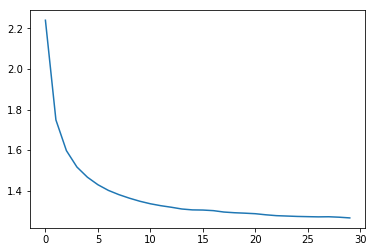

In [82]:
plt.plot(x, re_rnn_4times_para)

In [83]:
Tester(MyBasicRNNCell_4times_para)

there are preprocessed data - lets load it
[39  5  1  7  1  0  4  7  1  0 15  3 13  0 20  3  9  8 20  0  2  3 12  4
 15 44]
INFO:tensorflow:Restoring parameters from saved_model
num_batches 47
test loss: 1.4555537421652611


1.4555537421652611

In [89]:
synthesize_example_sentences(MyBasicRNNCell_4times_para)

*****Synthesizing: What is the meaning of life

there are preprocessed data - lets load it
[39  5  4  2  0  9  6  0  2  5  1  0 14  1  4  8  9  8 20  0  3 18  0 11
  9 18  1]
INFO:tensorflow:Restoring parameters from saved_model
What is the meaning of lifed to do the prince
Did not be no time, I'll go what hath take it ill,
Who hath made myself home is t

*****Synthesizing: I will be king, or die.

there are preprocessed data - lets load it
[21  0 17  9 11 11  0 22  1  0 28  9  8 20 16  0  3  7  0 12  9  1 25]
INFO:tensorflow:Restoring parameters from saved_model
I will be king, or die.

ANGELO:
'Tis we mocked thee
Why shall keep him, a gravely to see a man to shal a man's language ma

*****Synthesizing: Most noble sir

there are preprocessed data - lets load it
[42  3  6  2  0  8  3 22 11  1  0  6  9  7]
INFO:tensorflow:Restoring parameters from saved_model
Most noble sirah, I have bornes
And bid my love, sir.

DUCHESS OF YORK:
An if this is their days and many tongue t

*****Synthesi

## RNN -  Two Internal Layers

In [112]:
class MyBasicRNNCell_2internal_layers(tf.contrib.rnn.BasicRNNCell):

    def build(self, inputs_shape):

        input_depth = inputs_shape[1].value
        
        self._kernel = self.add_variable(name="kernel_hidden", shape=[input_depth + self._num_units, 2*self._num_units])
        self._bias = self.add_variable(name="bias_hidden", shape=[2*self._num_units], initializer=tf.zeros_initializer())
        
        self.built = True

    def call(self, inputs, state):
        """Most basic RNN: output = new_state = act(W * input + U * state + B)."""
        one = tf.constant(1, dtype=tf.int32)
        
        layers = tf.matmul(tf.concat([inputs, state], 1), self._kernel) + self._bias
        layer1, layer2 = tf.split(value=layers, num_or_size_splits=2, axis=one)
        
        output = tf.tanh(layer1 + layer2)
        
        return output, output

In [113]:
re_rnn_2internal_layers = trainer(MyBasicRNNCell_2internal_layers)

train_num_batches 185
epoch: 0 loss: 2.2272464114266475
epoch: 1 loss: 1.7737798748789606
epoch: 2 loss: 1.6404084418271039
epoch: 3 loss: 1.5698968204292092
epoch: 4 loss: 1.5259283735945417
epoch: 5 loss: 1.4960907865214992
epoch: 6 loss: 1.4746330209680505
epoch: 7 loss: 1.4586611612423046
epoch: 8 loss: 1.446395680711076
epoch: 9 loss: 1.437072643718204
epoch: 10 loss: 1.4295798359690486
epoch: 11 loss: 1.423808409716632
epoch: 12 loss: 1.4171869542147661
epoch: 13 loss: 1.411902405120231
epoch: 14 loss: 1.4072446771570155
epoch: 15 loss: 1.4043807880298511
epoch: 16 loss: 1.4008495846310178
epoch: 17 loss: 1.3982186130575232
epoch: 18 loss: 1.3954141681258743
epoch: 19 loss: 1.3941678549792316
epoch: 20 loss: 1.3924343714842926
epoch: 21 loss: 1.3922932263967154
epoch: 22 loss: 1.3908695659121952
epoch: 23 loss: 1.3889292652542526
epoch: 24 loss: 1.3874610076079497
epoch: 25 loss: 1.3857265453080874
epoch: 26 loss: 1.3852910467096278
epoch: 27 loss: 1.3855447910927436
epoch: 28 lo

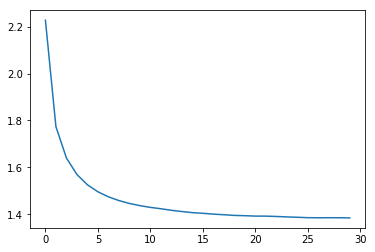

In [114]:
plt.plot(x, re_rnn_2internal_layers)

In [115]:
Tester(MyBasicRNNCell_2internal_layers)

there are preprocessed data - lets load it
[39  5  1  7  1  0  4  7  1  0 15  3 13  0 20  3  9  8 20  0  2  3 12  4
 15 44]
INFO:tensorflow:Restoring parameters from saved_model
num_batches 47
test loss: 1.4672466643313145


1.4672466643313145

In [116]:
synthesize_example_sentences(MyBasicRNNCell_2internal_layers)

*****Synthesizing: What is the meaning of life

there are preprocessed data - lets load it
[39  5  4  2  0  9  6  0  2  5  1  0 14  1  4  8  9  8 20  0  3 18  0 11
  9 18  1]
INFO:tensorflow:Restoring parameters from saved_model
What is the meaning of lifer--
Ah, hope--
Shamed and son,
And spoken a true our lips
We should need.

POLIXENES:
O side, and be

*****Synthesizing: I will be king, or die.

there are preprocessed data - lets load it
[21  0 17  9 11 11  0 22  1  0 28  9  8 20 16  0  3  7  0 12  9  1 25]
INFO:tensorflow:Restoring parameters from saved_model
I will be king, or die. Why there do not but see the part o' the partic in this child-body we through thy life than be tear

*****Synthesizing: Most noble sir

there are preprocessed data - lets load it
[42  3  6  2  0  8  3 22 11  1  0  6  9  7]
INFO:tensorflow:Restoring parameters from saved_model
Most noble sirah, the bonden the world bettard on him till me to the wars any
And the privose
Without myself
Becom

*****Synthesi

## RNN - Two Internal Layers & Increased Number of Parameters

In [92]:
re_rnn_2internal_layers_4times_para = trainer(MyBasicRNNCell_2internal_layers_4times_para)

train_num_batches 185
epoch: 0 loss: 2.4628151597203436
epoch: 1 loss: 1.90380372485599
epoch: 2 loss: 1.7446552920985867
epoch: 3 loss: 1.6610105546745093
epoch: 4 loss: 1.6015865577233803
epoch: 5 loss: 1.5705806803058933
epoch: 6 loss: 1.5397926208135244
epoch: 7 loss: 1.5148035332963274
epoch: 8 loss: 1.4980338289931014
epoch: 9 loss: 1.4853885090028918
epoch: 10 loss: 1.4776260891476194
epoch: 11 loss: 1.4684570016087712
epoch: 12 loss: 1.461190121238296
epoch: 13 loss: 1.4559758282996513
epoch: 14 loss: 1.4509213060946078
epoch: 15 loss: 1.4462822005555436
epoch: 16 loss: 1.441060896821924
epoch: 17 loss: 1.4381781217214225
epoch: 18 loss: 1.434085427103816
epoch: 19 loss: 1.4319981916530713
epoch: 20 loss: 1.4294467706938048
epoch: 21 loss: 1.427404953982379
epoch: 22 loss: 1.4257868528366089
epoch: 23 loss: 1.422520105903213
epoch: 24 loss: 1.420979416692579
epoch: 25 loss: 1.4201048863900674
epoch: 26 loss: 1.4185486084706074
epoch: 27 loss: 1.4219837272489393
epoch: 28 loss: 

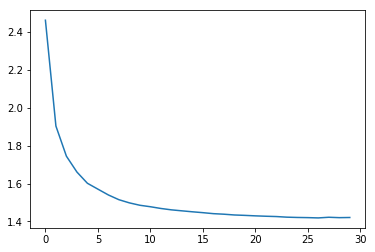

In [93]:
plt.plot(x, re_rnn_2internal_layers_4times_para)

In [94]:
Tester(MyBasicRNNCell_2internal_layers_4times_para)

there are preprocessed data - lets load it
[39  5  1  7  1  0  4  7  1  0 15  3 13  0 20  3  9  8 20  0  2  3 12  4
 15 44]
INFO:tensorflow:Restoring parameters from saved_model
num_batches 47
test loss: 1.4881689091946215


1.4881689091946215

In [95]:
synthesize_example_sentences(MyBasicRNNCell_2internal_layers_4times_para)

*****Synthesizing: What is the meaning of life

there are preprocessed data - lets load it
[39  5  4  2  0  9  6  0  2  5  1  0 14  1  4  8  9  8 20  0  3 18  0 11
  9 18  1]
INFO:tensorflow:Restoring parameters from saved_model
What is the meaning of lifess.

BIONDALLIUS:
I have
be the banos, the door sea,
When he is a secreath, and to think, whose brot

*****Synthesizing: I will be king, or die.

there are preprocessed data - lets load it
[21  0 17  9 11 11  0 22  1  0 28  9  8 20 16  0  3  7  0 12  9  1 25]
INFO:tensorflow:Restoring parameters from saved_model
I will be king, or die. What watch ye was alack'd, best to the day, that these possess, beseech you as he shall shade of th

*****Synthesizing: Most noble sir

there are preprocessed data - lets load it
[42  3  6  2  0  8  3 22 11  1  0  6  9  7]
INFO:tensorflow:Restoring parameters from saved_model
Most noble sirow: that he is not to seen yet your soul that honest was, many thee.

AEd OVELA:
The brave and blood

*****Synthesi

## LSTM - Coupled Forget and Input Gates

In [117]:
LSTMStateTuple = collections.namedtuple("LSTMStateTuple", ("c", "h"))

class LSTM_coupled_gates(tf.contrib.rnn.BasicLSTMCell):

    def build(self, inputs_shape):

        input_depth = inputs_shape[1].value
        self._kernel = self.add_variable(name="kernel", shape=[input_depth + self._num_units, 3 * self._num_units])
        self._bias = self.add_variable(name="bias", shape=[3 * self._num_units], initializer=tf.zeros_initializer())

        self.built = True

    def call(self, inputs, state):

        one = tf.constant(1, dtype=tf.int32)
        c, h = state

        gate_inputs = tf.matmul(tf.concat([inputs, h], axis=1), self._kernel) + self._bias

        forget_gate_weights, input_weights, output_gate_weights = tf.split(
            value=gate_inputs, num_or_size_splits=3, axis=one)

        # forget gating
        forget_bias_tensor = tf.constant(1.0, dtype=forget_gate_weights.dtype)
        forget_gate = tf.sigmoid(forget_gate_weights + forget_bias_tensor)
        gated_memory = c * forget_gate

        # input gating
        processed_new_input = tf.tanh(input_weights)
        input_gate = 1- forget_gate
        gated_input = input_gate * processed_new_input

        # updating memory
        new_c = gated_memory + gated_input

        # output gating
        processed_memory = tf.tanh(new_c)
        output_gate = tf.sigmoid(output_gate_weights)
        new_h = processed_memory * output_gate

        new_state = tf.nn.rnn_cell.LSTMStateTuple(new_c, new_h)

        return new_h, new_state

In [118]:
re_lstm_coupled_gates = trainer(LSTM_coupled_gates)

train_num_batches 185
epoch: 0 loss: 2.409353798788947
epoch: 1 loss: 1.7852047185640076
epoch: 2 loss: 1.5993500838408599
epoch: 3 loss: 1.5059271168064428
epoch: 4 loss: 1.4488819637814083
epoch: 5 loss: 1.4099241765769752
epoch: 6 loss: 1.3796351825868762
epoch: 7 loss: 1.3550755861643198
epoch: 8 loss: 1.3352400689511685
epoch: 9 loss: 1.3185839317940378
epoch: 10 loss: 1.3043541843826707
epoch: 11 loss: 1.292736376942815
epoch: 12 loss: 1.2817442861763206
epoch: 13 loss: 1.2705455309635885
epoch: 14 loss: 1.2613933247488898
epoch: 15 loss: 1.2536882316744005
epoch: 16 loss: 1.2444923858384829
epoch: 17 loss: 1.2366484732241243
epoch: 18 loss: 1.2301244967692606
epoch: 19 loss: 1.225012719309008
epoch: 20 loss: 1.2214184754603619
epoch: 21 loss: 1.2191382040848604
epoch: 22 loss: 1.2149888090185217
epoch: 23 loss: 1.2090783911782341
epoch: 24 loss: 1.2044905011718336
epoch: 25 loss: 1.2013151890522724
epoch: 26 loss: 1.1981754006566228
epoch: 27 loss: 1.1933747536427266
epoch: 28 l

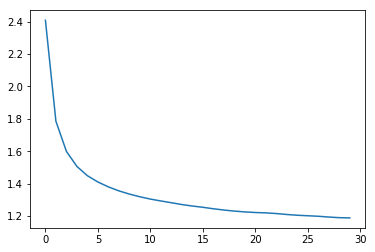

In [119]:
plt.plot(x, re_lstm_coupled_gates)

In [120]:
Tester(LSTM_coupled_gates)

there are preprocessed data - lets load it
[39  5  1  7  1  0  4  7  1  0 15  3 13  0 20  3  9  8 20  0  2  3 12  4
 15 44]
INFO:tensorflow:Restoring parameters from saved_model
num_batches 47
test loss: 1.4013547973429903


1.4013547973429903

In [121]:
synthesize_example_sentences(LSTM_coupled_gates)

*****Synthesizing: What is the meaning of life

there are preprocessed data - lets load it
[39  5  4  2  0  9  6  0  2  5  1  0 14  1  4  8  9  8 20  0  3 18  0 11
  9 18  1]
INFO:tensorflow:Restoring parameters from saved_model
What is the meaning of lifed immartive;
For I will, nothing on him three homaly
That I might here one an old curtain'd to heart

*****Synthesizing: I will be king, or die.

there are preprocessed data - lets load it
[21  0 17  9 11 11  0 22  1  0 28  9  8 20 16  0  3  7  0 12  9  1 25]
INFO:tensorflow:Restoring parameters from saved_model
I will be king, or die.

QUEEN ELIZABETH:
What is that doth he that said what thou hast,
Cast one shorted damnedy.
In grave

*****Synthesizing: Most noble sir

there are preprocessed data - lets load it
[42  3  6  2  0  8  3 22 11  1  0  6  9  7]
INFO:tensorflow:Restoring parameters from saved_model
Most noble sirs,
So sworn their suffing to decorue your house
With mends upon the throngs and mercy as it,
Want as

*****Synthesi

## LSTM - Gated Recurrent Unit, or GRU

In [51]:
LSTMStateTuple = collections.namedtuple("LSTMStateTuple", ("c", "h"))

class LSTMCell_GRU(tf.contrib.rnn.BasicLSTMCell):

    def build(self, inputs_shape):

        input_depth = inputs_shape[1].value
        self._kernel = self.add_variable(name="kernel", shape=[input_depth + self._num_units, 2 * self._num_units])
        self._bias = self.add_variable(name="bias", shape=[2 * self._num_units], initializer=tf.zeros_initializer())

        self._kernel2 = self.add_variable(name="kernel2", shape=[input_depth + self._num_units, self._num_units])
        self._bias2 = self.add_variable(name="bias2", shape=[self._num_units], initializer=tf.zeros_initializer())
        
        self.built = True

    def call(self, inputs, state):

        one = tf.constant(1, dtype=tf.int32)
        c, h = state
        c = h
        
        gate_inputs = tf.matmul(tf.concat([inputs, h], axis=1), self._kernel) + self._bias

        z_weights, r_weights = tf.split(value=gate_inputs, num_or_size_splits=2, axis=one)
        z = tf.sigmoid(z_weights)
        r = tf.sigmoid(r_weights)
        
        h_weights = tf.matmul(tf.concat([inputs, r*c], axis=1), self._kernel2) + self._bias2
        h_hat = tf.tanh(h_weights)
        
        new_h = (1-z) * h + z*h_hat
        new_c = new_h
        
        new_state = tf.nn.rnn_cell.LSTMStateTuple(new_c, new_h)

        return new_h, new_state

In [52]:
re_lstm_gru = trainer(LSTMCell_GRU)

train_num_batches 185
epoch: 0 loss: 2.355442088359111
epoch: 1 loss: 1.7596241261508014
epoch: 2 loss: 1.5759504646868319
epoch: 3 loss: 1.4850551012400035
epoch: 4 loss: 1.428617400736422
epoch: 5 loss: 1.3893563483212445
epoch: 6 loss: 1.3598877410630923
epoch: 7 loss: 1.336328884073206
epoch: 8 loss: 1.3159074809100177
epoch: 9 loss: 1.2987315867398237
epoch: 10 loss: 1.2845142706020458
epoch: 11 loss: 1.2701163259712425
epoch: 12 loss: 1.2577105947442957
epoch: 13 loss: 1.246971026626793
epoch: 14 loss: 1.2383390317092071
epoch: 15 loss: 1.2306140242396175
epoch: 16 loss: 1.2207888345460634
epoch: 17 loss: 1.212768757021105
epoch: 18 loss: 1.206324323447975
epoch: 19 loss: 1.2014731677802832
epoch: 20 loss: 1.1986860185056118
epoch: 21 loss: 1.1985458876635577
epoch: 22 loss: 1.1966996392688236
epoch: 23 loss: 1.1934569661681715
epoch: 24 loss: 1.1897458327783121
epoch: 25 loss: 1.1862132413967235
epoch: 26 loss: 1.182631953342541
epoch: 27 loss: 1.1798216665113295
epoch: 28 loss:

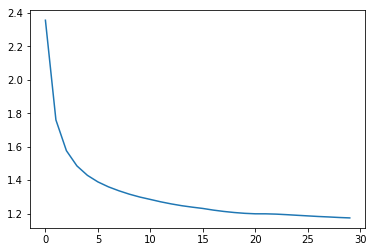

In [53]:
plt.plot(x, re_lstm_gru)

In [55]:
Tester(LSTMCell_GRU)

there are preprocessed data - lets load it
[39  5  1  7  1  0  4  7  1  0 15  3 13  0 20  3  9  8 20  0  2  3 12  4
 15 44]
INFO:tensorflow:Restoring parameters from saved_model
num_batches 47
test loss: 1.4563161895630208


1.4563161895630208

In [56]:
Synthesize(LSTMCell_GRU,"What is the meaning of life")

there are preprocessed data - lets load it
[39  5  4  2  0  9  6  0  2  5  1  0 14  1  4  8  9  8 20  0  3 18  0 11
  9 18  1]
INFO:tensorflow:Restoring parameters from saved_model
What is the meaning of lifen of his
blutes fierces, be the shade of mind
What issue in thyself to make thee, have the wretest
I


In [57]:
Synthesize(LSTMCell_GRU,"Farewell")

there are preprocessed data - lets load it
[49  4  7  1 17  1 11 11]
INFO:tensorflow:Restoring parameters from saved_model
Farewellos,
We have made mourning; and in this sounds
The swear to the brother will not breathed.
I will tha


In [58]:
Synthesize(LSTMCell_GRU,"O my lord")

there are preprocessed data - lets load it
[32  0 14 15  0 11  3  7 12]
INFO:tensorflow:Restoring parameters from saved_model
O my lord,
Our arch-station to the people, sir,
With whose souls of blood in the seats of the fishes,
Still c


In [59]:
Synthesize(LSTMCell_GRU,"Most noble sir")

there are preprocessed data - lets load it
[42  3  6  2  0  8  3 22 11  1  0  6  9  7]
INFO:tensorflow:Restoring parameters from saved_model
Most noble sir's war,
That that's the bought made made a soldier than take up
Inest together to the bridegry finge


In [60]:
Synthesize(LSTMCell_GRU,"I will be king, or die.")

there are preprocessed data - lets load it
[21  0 17  9 11 11  0 22  1  0 28  9  8 20 16  0  3  7  0 12  9  1 25]
INFO:tensorflow:Restoring parameters from saved_model
I will be king, or die.

Nurse:
O so see against my brother's estimate his trade.
Take my liege and hopeful tonguest, how s


In [28]:
def Synthesize(MyCell,init_string="None"):
    tf.reset_default_graph()
    num_steps_bak=args.num_steps
    batch_size_bak=args.batch_size
    args.num_steps=1
    args.batch_size=1
    with tf.variable_scope('placeholders'):
            inputs = tf.placeholder(tf.int32, [args.batch_size, args.num_steps])
            targets = tf.placeholder(tf.int32, [args.batch_size, args.num_steps])
    init_state, train_step, loss, final_state, saver, prob=network(MyCell,inputs,targets)

    # Define initialization
    if (init_string is None):
        initialization = 'Where are you going today?'
    else:
        initialization = init_string
    loader= TextLoader(args.data_dir, batch_size=1, seq_length=1)

    forecast_data=np.array(list(map(loader.vocab_to_idx.get, initialization)))
    print(forecast_data)
    forecast_range = 100
    top_k=5
 
    with tf.Session() as sess:

        # Load saved model
        saver.restore(sess, 'saved_model')
        state_ = sess.run(init_state)

        # Run rnn on initialization data to get final hidden state before simulation
        state_ = sess.run(init_state)
        for i in range(forecast_data.shape[0]):

            feed_dict = dict()
            # Feed current predicted
            feed_dict[inputs] = forecast_data[i].reshape(args.batch_size, args.num_steps)
            if ('RNN' in MyCell.__name__):
                feed_dict[init_state] = state_
            else:
                feed_dict[init_state.c] = state_.c
                feed_dict[init_state.h] = state_.h
            # Get new hidden state and prediction probabilities
            predicted_prob, state_ = sess.run([prob, final_state], feed_dict=feed_dict)

        # last state of this step becomes first state of simulation

        for i in range(forecast_range):

            feed_dict = dict()
            # Feed current predicted
            feed_dict[inputs] = forecast_data[-args.num_steps:].reshape(args.batch_size, args.num_steps)
            if ('RNN' in MyCell.__name__):
                feed_dict[init_state] = state_
            else:
                feed_dict[init_state.c] = state_.c
                feed_dict[init_state.h] = state_.h
            predicted_prob, state_ = sess.run([prob, final_state], feed_dict=feed_dict)

            predicted_prob = predicted_prob.ravel()
            # Simulate from top top_k probs
            predicted_prob[np.argsort(predicted_prob)[:-top_k]] = 0
            predicted_prob = predicted_prob/np.sum(predicted_prob)
            sample = np.random.choice(args.num_chars, 1, p=predicted_prob)[0]


            forecast_data = np.hstack((forecast_data, sample))

    forecasted_chars = np.asarray([loader.idx_to_vocab[elem] for elem in forecast_data])

    print(''.join(forecasted_chars))
  
    args.num_steps=num_steps_bak
    args.batch_size=batch_size_bak

In [32]:
def Tester(MyCell, num_batches=None):
    tf.reset_default_graph()
    with tf.variable_scope('placeholders'):
            inputs = tf.placeholder(tf.int32, [args.batch_size, args.num_steps])
            targets = tf.placeholder(tf.int32, [args.batch_size, args.num_steps])
    init_state, train_step, loss, final_state, saver, prob=network(MyCell,inputs,targets)

    # Define initialization
    initialization = 'Where are you going today?'
    loader= TextLoader(args.data_dir, batch_size=args.batch_size, seq_length=args.num_steps)

    forecast_data=np.array(list(map(loader.vocab_to_idx.get, initialization)))
    print(forecast_data)
    forecast_range = 100
    top_k=5
 
    if (num_batches is None):
        num_batches=loader.test_num_batches
    with tf.Session() as sess:

        # Load saved model
        saver.restore(sess, 'saved_model')
        state_ = sess.run(init_state)

        loader.reset_batch_pointer()
        
         # Get test error loss
        test_loss = 0
        print('num_batches',num_batches)

        for batch in range(num_batches):

            x, y = loader.next_batch_test()

            feed_dict = dict()
            feed_dict[inputs] = x
            feed_dict[targets] = y

            if ('RNN' in MyCell.__name__):
                feed_dict[init_state] = state_
            else:
                feed_dict[init_state.c] = state_.c
                feed_dict[init_state.h] = state_.h

            test_loss_, state_= sess.run([loss, final_state], feed_dict=feed_dict)
            test_loss += test_loss_
        test_loss=test_loss/num_batches
        print('test loss:',  test_loss)


    
    return(test_loss)

# II. Report & Analysis

### Basic RNN
    - Loss of training data at 30th epoch: 1.348
    - Loss on test data: 1.465
    - Synthesis performance: 
        The synthesis on chosen 5 example sentences did not quite make sense. The words predicted were not in strong relationship with the prime sentences, nor were they making sense by themselves.
    - Comparison with basic LSTM:
        a). Compared to basic LSTM, both the loss on training data and loss on test data are higher, validating the fact that LSTM is better at holding information far away ahead.
        b). The training error plot shows that the loss decreases faster than that of the basic LSTM at the beginning but turned slower as the epoch number increases. The training loss decreases at descent rate even towards the end of the training. 

### RNN with same number of parameters as the LSTM
Increase the number of parameters by multiplying the original num_units by 2, thus generating weights and biases of 4 times number of parameters to that of the original RNN model. The new model has the same number of parameters at the LSTM. 
    - Loss of training data at 30th epoch: 1.266
    - Loss on test data: 1.456
    - Synthesis performance: 
        Performed better than basic RNN on sentence "O my Lord" and "Most noble sir". The sentences predicted after correspond with the meanings of and words in the two sentences. For example, the predicted sentence contains the word "sir" for the "Most noble sir". The performance on other three sentences is not distinguishably better than that of the basic RNN.
    - Comparison:
        Compared to basic RNN, this model results in lower loss on training data but similar loss on test data. However, with the same number of parameters with the basic LSTM, the loss on training set is still higher than that of the basic LSTM. This might be due to that increasing the number of parameters will improve fitting of the RNN on training data, but will not necessarily show improved performance on test data, and will not handle "long-term dependencies". The performance on sythesizing is slightly better than that of the basic RNN. 

### RNN with 2 internal layers
Adding another internal layer to the basic RNN model. 
    - Loss of training data at 30th epoch: 1.385
    - Loss on test data: 1.467
    - Synthesis performance: 
        The performance on sythesizing is similar to that of the basic RNN model.
    - Comparison:
        Compared to basic RNN model, the performances on the training data and test data drop down. 

### RNN with 2 internal layers and increased number of parameters 
Both adding another internal layer and increasing the number of parameters to the original RNN model. 
    - Loss of training data at 30th epoch: 1.421
    - Loss on test data: 1.488
    - Synthesis performance:
        The performance on sythesizing is similar to that of the basic RNN model.
    - Comparison:
        The performances on the training data and test data drop down compared to both the RNN with only increased 
        number of internal layers and increased number of parameters.

### Basic LSTM
    - Loss of training data at 30th epoch: 1.1987495609231897
    - Loss on test data: 1.397
    - Synthesis performance:
        It is quite notable that the characters predicted can make good sense. 

### LSTM with coupled forget and input gates
Implementing the LSTM with coupled forget and input gates introduced at http://colah.github.io/posts/2015-08-Understanding-LSTMs/
    - Loss of training data at 30th epoch: 1.188
    - Loss on test data: 1.401
    - Synthesis performance: 
        Better than RNNs.
    - Comparison:
        The loss on training data is lower than that of the basic LSTM. The loss on test data is similar to that of 
        the basic LSTM. Overall, the model does a good job on predicting characters.

### Gated Recurrent Unit (GRU)
Implementing the GRU introduced at http://colah.github.io/posts/2015-08-Understanding-LSTMs/
    - Loss of training data at 30th epoch: 1.174
    - Loss on test data: 1.456
    - Synthesis performance:
        Better than RNNs.
    - Comparison:
        The loss on training data is lower than that of the basic LSTM and that of the LSTM with coupled forget and 
        input gates. However, the loss on test data is notably higher than both. 

### Prime sentences used in example synthesis and the text after

I will be king, or die.
Brother, thou shalt to London presently,
And whet on Warwick to this enterprise.
Thou, Richard, shalt to the Duke of Norfolk,
And tell him privily of our intent.
You Edward, shall unto my Lord Cobham,
With whom the Kentishmen will willingly rise:
In them I trust; for they are soldiers,
Witty, courteous, liberal, full of spirit.
While you are thus employ'd, what resteth more,
But that I seek occasion how to rise,
And yet the king not privy to my drift,
Nor any of the house of Lancaster?
But, stay: what news? Why comest thou in such post?

O my lord!
I would your spirit were easier for advice,
Or stronger for your need.

First Senator:
Farewell.

Second Senator:
Farewell.

All:
Farewell.

I do; and surely
It is a sleepy language and thou speak'st
Out of thy sleep. What is it thou didst say?
This is a strange repose, to be asleep
With eyes wide open; standing, speaking, moving,
And yet so fast asleep.

Most noble sir,
That which I shall report will bear no credit,
Were not the proof so nigh. Please you, great sir,
Bohemia greets you from himself by me;
Desires you to attach his son, who has--
His dignity and duty both cast off--
Fled from his father, from his hopes, and with
A shepherd's daughter.